# Simulation of Vertical Federated Learning with VFL Trainer and Aggregator

In [1]:
import torch
import torch.nn as nn
from omegaconf import DictConfig
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from vfl_trainer import VFLTrainer
from vfl_aggregator import VFLAggregator

# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [2]:
class DiabetesClientEmbeddingModel(nn.Module):
    """
    Embedding model for the VFL clients.
    """
    def __init__(self, input_dim, output_dim=8, hidden_dim=24):
        super(DiabetesClientEmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x
    
class DiabetesServerModel(nn.Module):
    """
    Model for the VFL server.
    """
    def __init__(self, input_dim, output_dim=1, hidden_dim=12):
        super(DiabetesServerModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Create client embedding models and server model
client1_embedding_model = DiabetesClientEmbeddingModel(input_dim=3, output_dim=8, hidden_dim=24)
client2_embedding_model = DiabetesClientEmbeddingModel(input_dim=3, output_dim=8, hidden_dim=24)
client3_embedding_model = DiabetesClientEmbeddingModel(input_dim=4, output_dim=8, hidden_dim=24)
server_model = DiabetesServerModel(input_dim=24, output_dim=1, hidden_dim=12)
# Prepare the training data for each client
X_train_client1 = X_train[:, :3]
X_train_client2 = X_train[:, 3:6]
X_train_client3 = X_train[:, 6:]
# Prepare the testing data for each client
X_test_client1 = X_test[:, :3]
X_test_client2 = X_test[:, 3:6]
X_test_client3 = X_test[:, 6:]

In [4]:
trainer_config = DictConfig({
    "device": "cpu",
    "optim": "Adam",
    "optim_args": {"lr": 0.01},
})
aggregator_config = DictConfig({
    "device": "cpu",
    "optim": "Adam",
    "optim_args": {"lr": 0.01},
    "loss_fn": "MSELoss",
    "server_label_path": "./server_labels.py",
    "server_label_fn": "get_labels",
    "validation": True,
    "validation_interval": 50,
})

In [5]:
trainer_1 = VFLTrainer(
    model=client1_embedding_model,
    train_dataset=X_train_client1,
    val_dataset=X_test_client1,
    train_configs=trainer_config,
)
trainer_2 = VFLTrainer(
    model=client2_embedding_model,
    train_dataset=X_train_client2,
    val_dataset=X_test_client2,
    train_configs=trainer_config,
)
trainer_3 = VFLTrainer(
    model=client3_embedding_model,
    train_dataset=X_train_client3,
    val_dataset=X_test_client3,
    train_configs=trainer_config,
)
aggregator = VFLAggregator(
    model=server_model,
    aggregator_configs=aggregator_config,
)

In [6]:
num_epochs = 500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    trainer_1.train()
    trainer_2.train()
    trainer_3.train()
    
    client1_params = trainer_1.get_parameters()
    client2_params = trainer_2.get_parameters()
    client3_params = trainer_3.get_parameters()
    
    # Train the server model
    res = aggregator.aggregate(
        [
            client1_params,
            client2_params,
            client3_params,
        ]
    )

    trainer_1.load_parameters(res[0])
    trainer_2.load_parameters(res[1])
    trainer_3.load_parameters(res[2])


Round 50: Training Loss: 4931.63134765625, Validation Loss: 4597.1982421875
Round 100: Training Loss: 3005.509521484375, Validation Loss: 3103.68408203125
Round 150: Training Loss: 2839.82861328125, Validation Loss: 2884.607421875
Round 200: Training Loss: 2761.023681640625, Validation Loss: 2762.208251953125
Round 250: Training Loss: 2712.88525390625, Validation Loss: 2708.015380859375
Round 300: Training Loss: 2678.0498046875, Validation Loss: 2681.894775390625
Round 350: Training Loss: 2648.883056640625, Validation Loss: 2673.649169921875
Round 400: Training Loss: 2621.296875, Validation Loss: 2676.94091796875
Round 450: Training Loss: 2588.421142578125, Validation Loss: 2673.494873046875
Round 500: Training Loss: 2534.657470703125, Validation Loss: 2728.8525390625


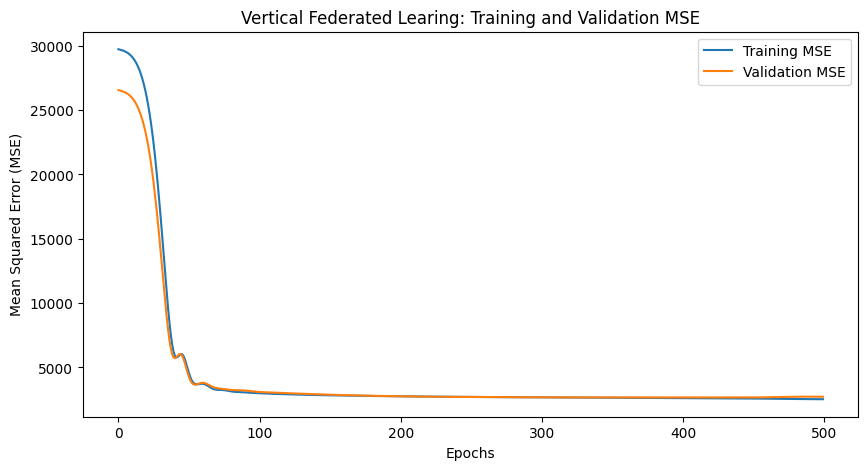

In [7]:
aggregator.plot_loss()